In [21]:
# This script will find the most recent CSV in pyquant/outputs,
# read the symbols, download historical data, generate candlestick charts,
# and save them to a single PDF.

import os
import glob
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
from matplotlib.backends.backend_pdf import PdfPages
import ta

In [22]:
def compute_qdqu_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Calculate EMAs
    week_ema_indicator = ta.trend.EMAIndicator(close=df['Close'], window=7)
    line_ema_indicator = ta.trend.EMAIndicator(close=df['Close'], window=20)
    qtr_ema_indicator = ta.trend.EMAIndicator(close=df['Close'], window=90)

    df['week_ema'] = week_ema_indicator.ema_indicator()
    df['line_ema'] = line_ema_indicator.ema_indicator()
    df['qtr_ema'] = qtr_ema_indicator.ema_indicator()

    # EMA deltas
    df['week_delta'] = df['week_ema'] - df['week_ema'].shift(1)
    df['qtr_delta'] = df['qtr_ema'] - df['qtr_ema'].shift(1)

    # Direction flags
    df['week_up'] = df['week_delta'] > 0
    df['week_down'] = df['week_delta'] < 0
    df['qtr_up'] = df['qtr_delta'] > 0
    df['qtr_down'] = df['qtr_delta'] < 0

    # Entry signals
    df['bull_entry'] = df['week_down'].shift(1) & df['week_up'] & df['qtr_up']
    df['bear_entry'] = df['week_up'].shift(1) & df['week_down'] & df['qtr_down']

    return df

In [23]:
# 1. Find the most recent CSV file in pyquant/outputs
output_dir = './outputs'
csv_files = glob.glob(os.path.join(output_dir, '*.csv'))

if not csv_files:
    print("No CSV files found in the outputs directory.")

most_recent_csvs = sorted(csv_files, key=os.path.getmtime, reverse=True)[:8]
print(f"Using the most recent CSV file: {most_recent_csvs}")

Using the most recent CSV file: ['./outputs\\2025-05-24_month_down_week_up&month_up_week_down.csv', './outputs\\2025-05-24_qtr_down_week_up&qtr_up_week_down.csv', './outputs\\2025-05-23_qtr_up_week_down.csv', './outputs\\2025-05-23_qtr_down_week_up.csv']


In [24]:
# 2. Read the CSV
df = pd.DataFrame()
for f in most_recent_csvs:
    try:
        df = pd.concat([df, pd.read_csv(f, sep='|')])
    except Exception as e:
        print(f"Error reading CSV file: {e}")

In [25]:
# 3. Get all of the files in the column called 'symbol'
if 'symbol' not in df.columns:
    print("CSV file does not contain a 'symbol' column.")
print(df.columns)

symbols = set(df['symbol'].tolist())
print(f"Found {len(symbols)} symbols: {symbols}")

Index(['symbol', 'volume', 'price_to_earnings', 'forward_pe', 'peg_ratio',
       'price_to_sales', 'price_to_book', 'price_to_cash',
       'eps_growth_past_1y', 'eps_growth_next_1y', 'eps_growth_past_5y',
       'eps_growth_next_5y', 'sales_growth_past_5y', 'price_to_free_cash_flow',
       'earnings_date', 'dividend_yield', 'return_on_assets',
       'return_on_equity', 'return_on_investment', 'long_term_debt_to_equity',
       'debt_to_equity', 'gross_margin', 'operating_margin', 'profit_margin',
       'current_ratio', 'quick_ratio', 'volume_avg', 'shares_outstanding',
       'shares_float', 'short_ratio', 'insider_ownership',
       'insider_ownership_change', 'institutional_ownership',
       'institutional_ownership_change', 'Short Float',
       'analyst_recommendation', 'volume_relative', 'price_change_1w',
       'price_change_1m', 'price_change_3m', 'price_change_6m',
       'price_change_1y', 'price_change_ytd', 'volatility_1w', 'volatility_1m',
       'beta', 'gap', 'aver

Generating chart for NAK...
Generating chart for BLND...
Generating chart for VSCO...
Generating chart for AER...
Generating chart for ADBE...
Error generating chart for ADBE: zero-size array to reduction operation maximum which has no identity
Generating chart for BE...
Generating chart for NE...
Error generating chart for NE: zero-size array to reduction operation maximum which has no identity
Generating chart for CFG...
Generating chart for HEFA...
Generating chart for MBOT...
Generating chart for SEE...
Generating chart for CSX...
Generating chart for S...
Generating chart for IEI...
Generating chart for ZTS...
Generating chart for SCHR...
Generating chart for SCO...
Generating chart for DD...
Generating chart for ADSK...
Generating chart for BWA...
Generating chart for RKT...
Generating chart for SPTI...
Generating chart for ACVA...
Generating chart for COWZ...
Generating chart for PSN...
Generating chart for SIRI...
Generating chart for ILMN...
Generating chart for BA...
Generati

c:\Users\maxw2\Desktop\quanticon\.venv\Lib\site-packages\mplfinance\plotting.py:476: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Generating chart for NWL...
Generating chart for QQQI...
Generating chart for SCHO...
Error generating chart for SCHO: zero-size array to reduction operation maximum which has no identity
Generating chart for RCAT...
Generating chart for CSTM...
Generating chart for HPE...
Generating chart for VTWO...
Generating chart for GTM...
Generating chart for VUZI...
Generating chart for AMPX...
Generating chart for TMUS...
Generating chart for SO...
Generating chart for ARBE...
Generating chart for DVAX...
Generating chart for DTE...
Generating chart for ASAN...
Generating chart for SQQQ...
Generating chart for ARWR...
Generating chart for DUK...
Generating chart for SRAD...
Error generating chart for SRAD: zero-size array to reduction operation maximum which has no identity
Generating chart for ULTY...
Generating chart for CIFR...
Generating chart for NKE...
Generating chart for AM...
Generating chart for EMXC...
Generating chart for TEM...
Generating chart for DDOG...
Generating chart for OND

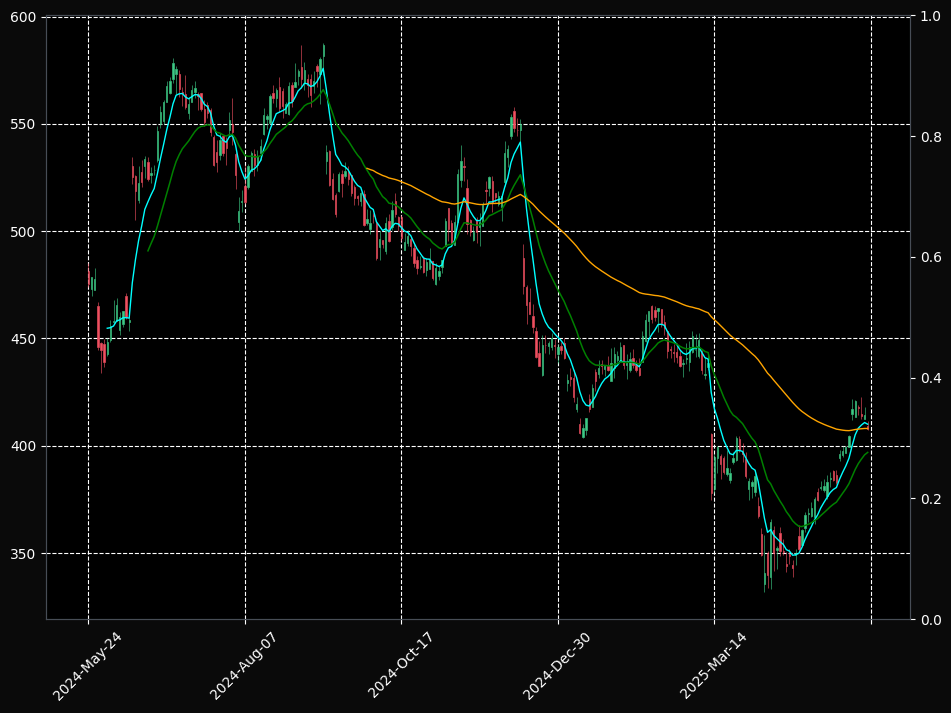

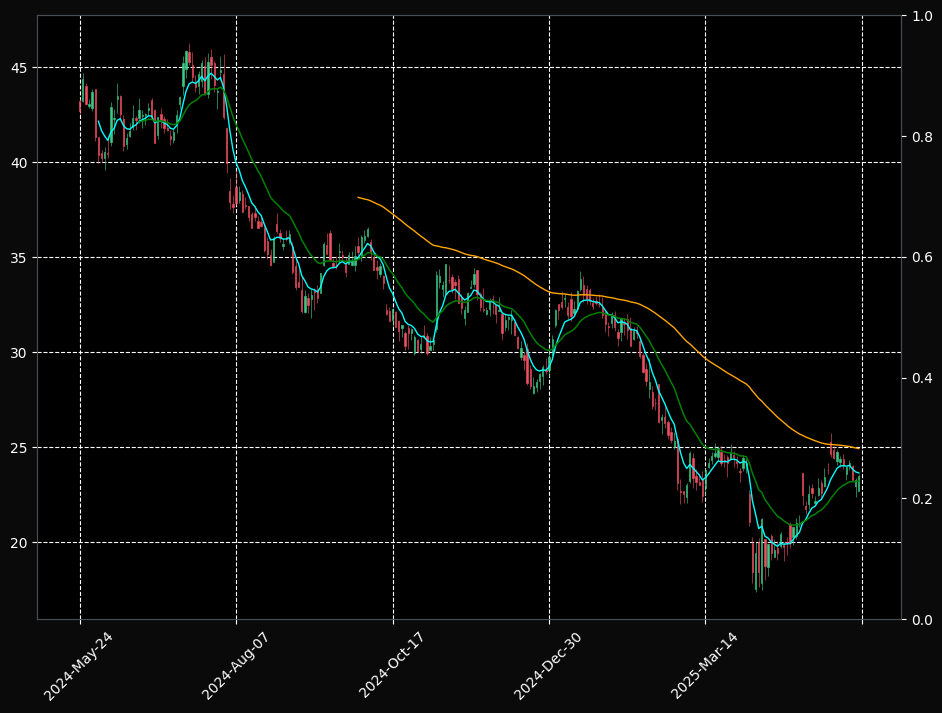

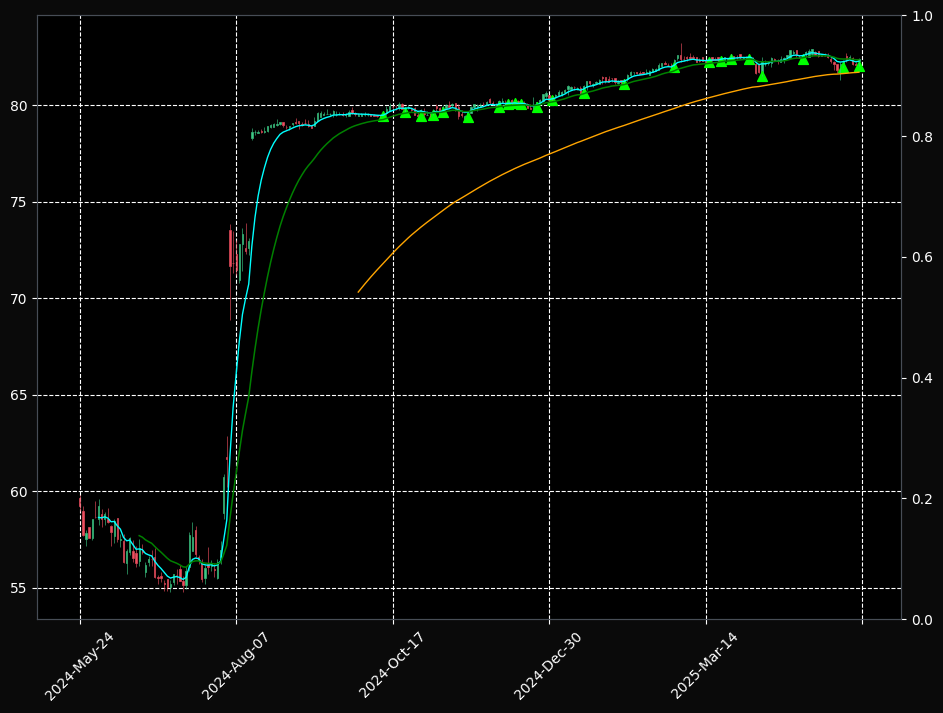

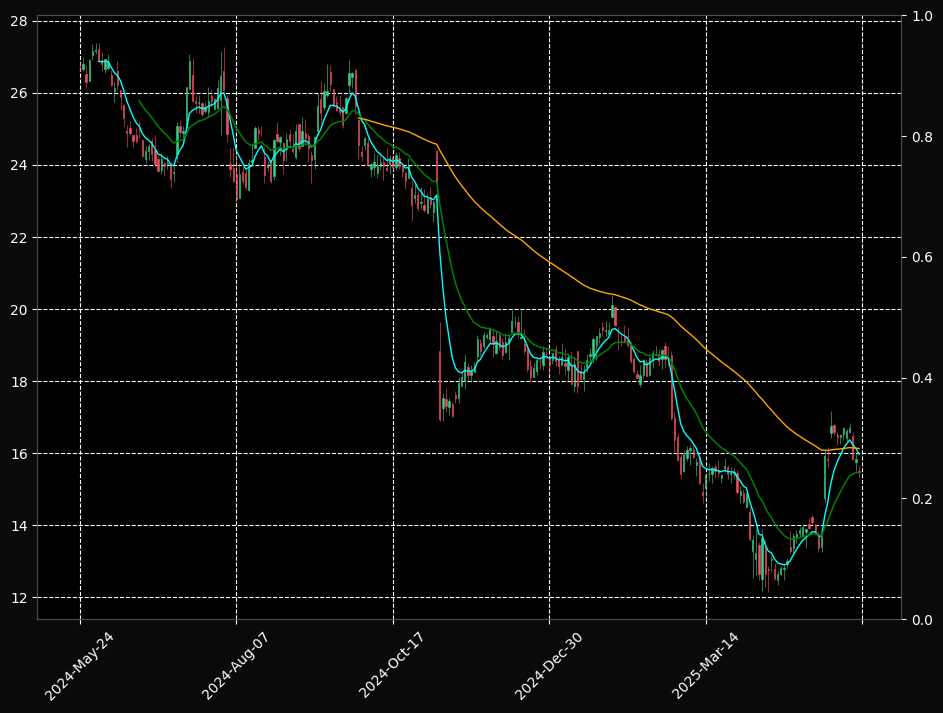

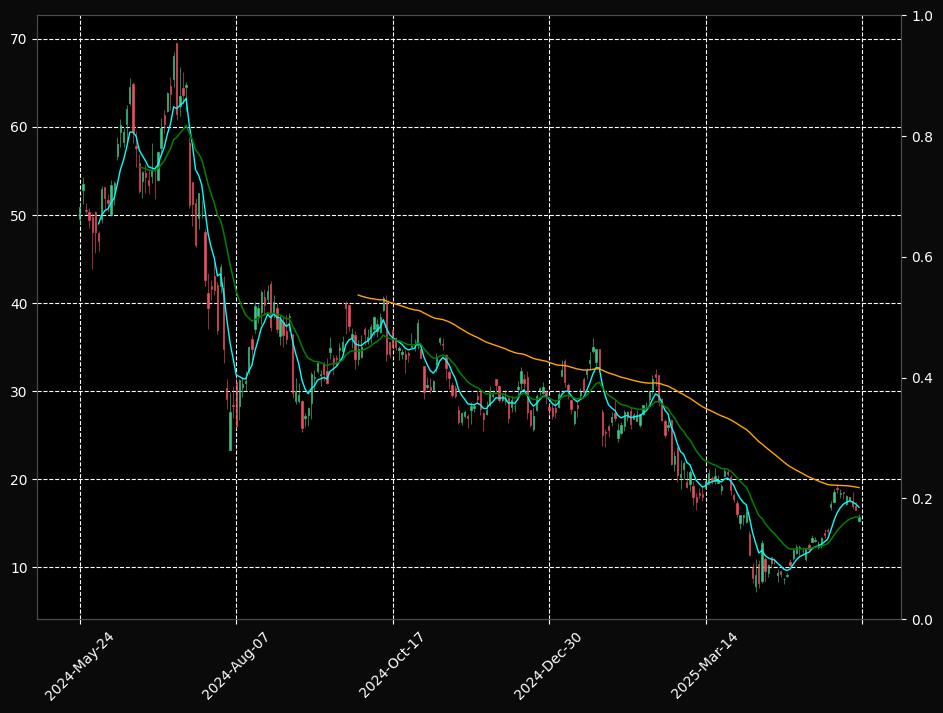

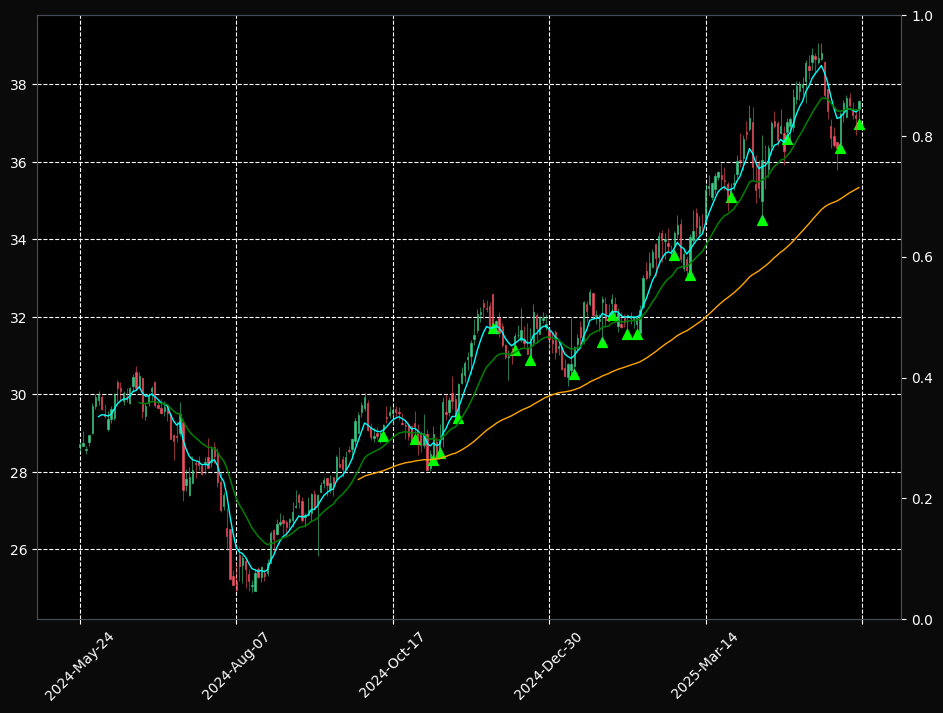

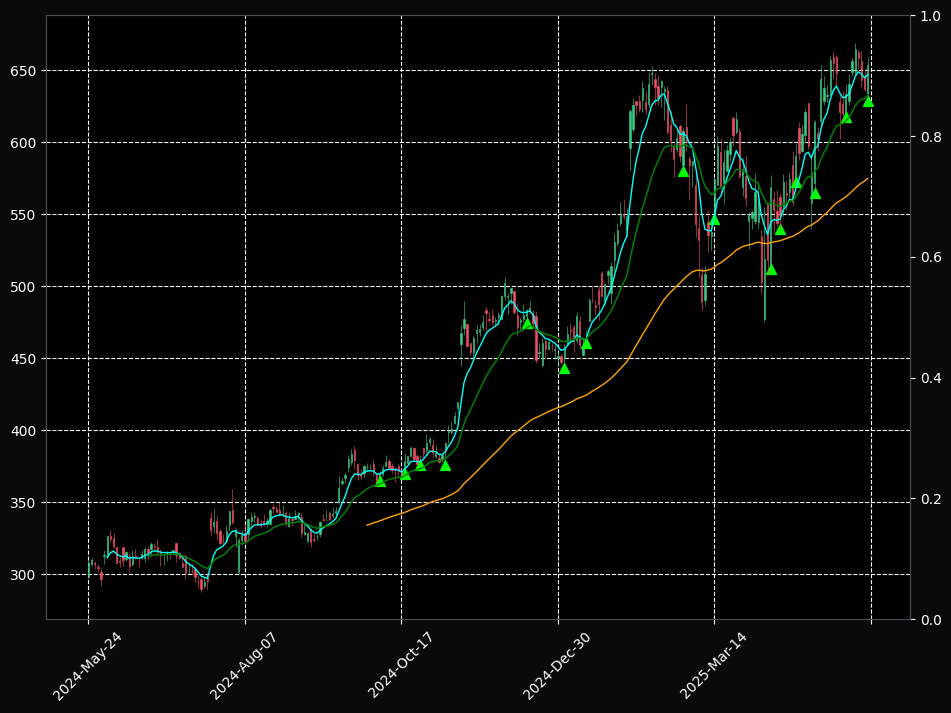

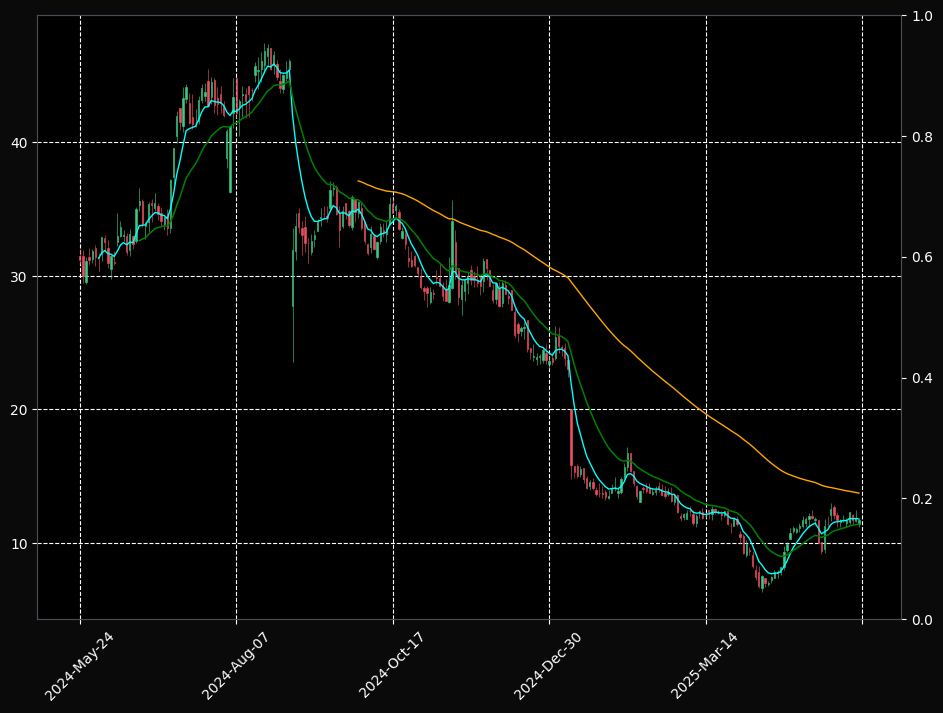

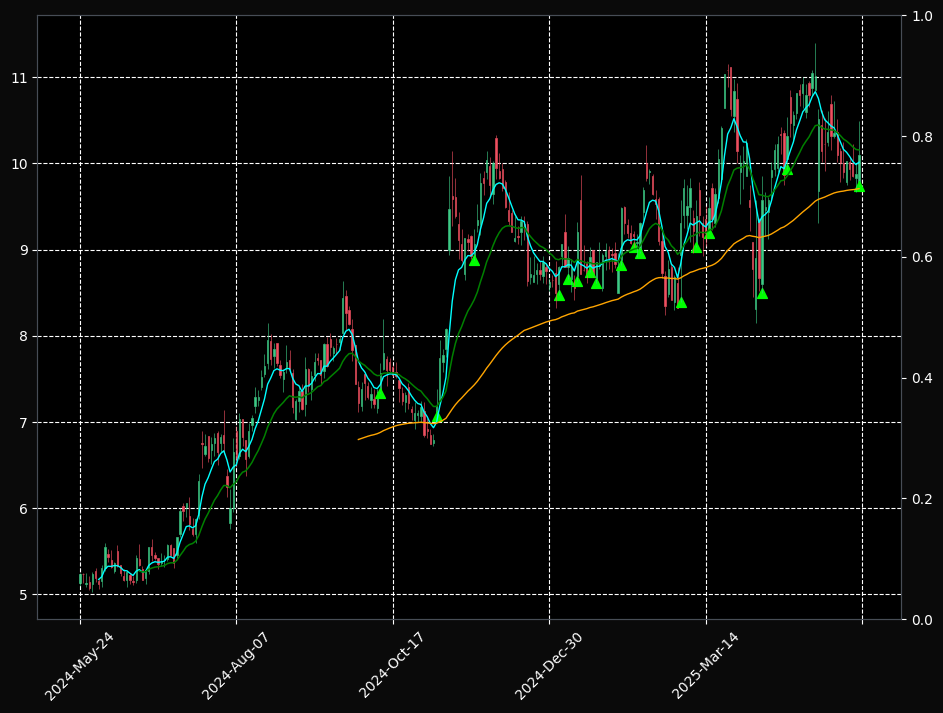

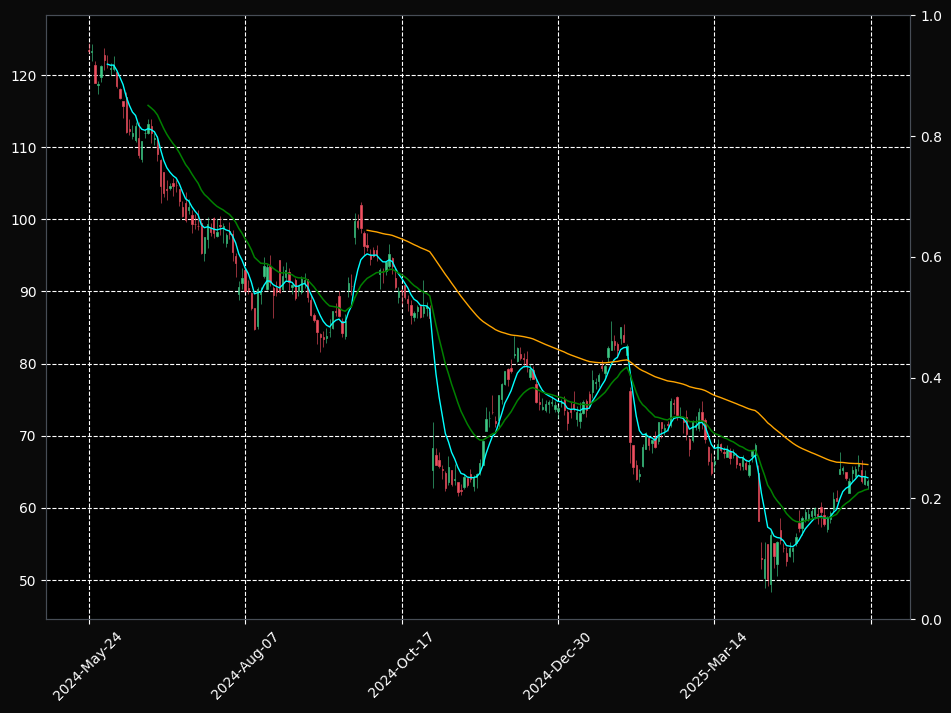

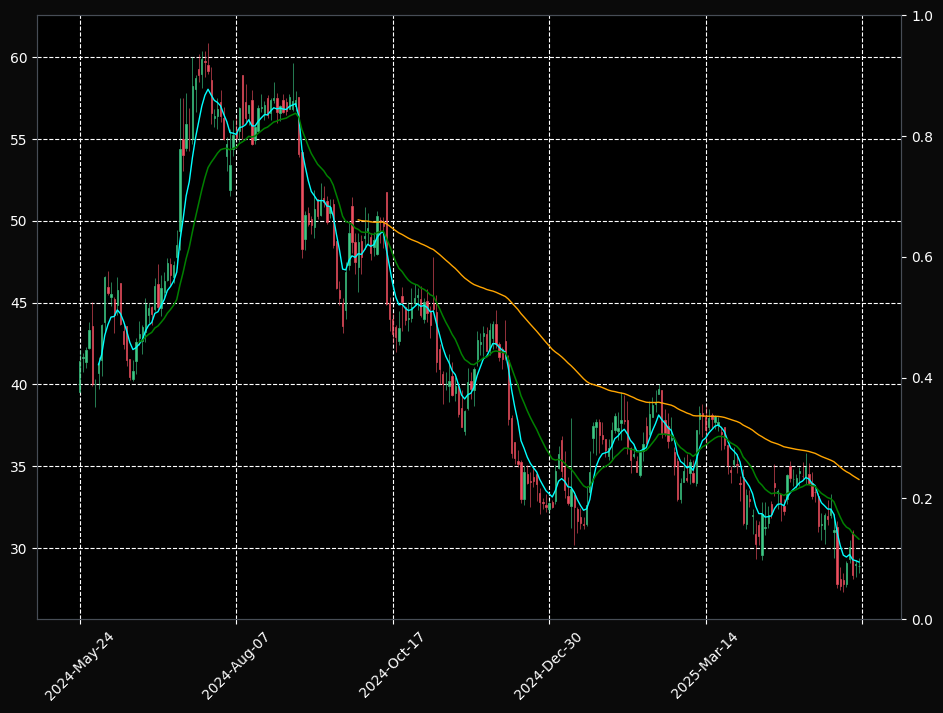

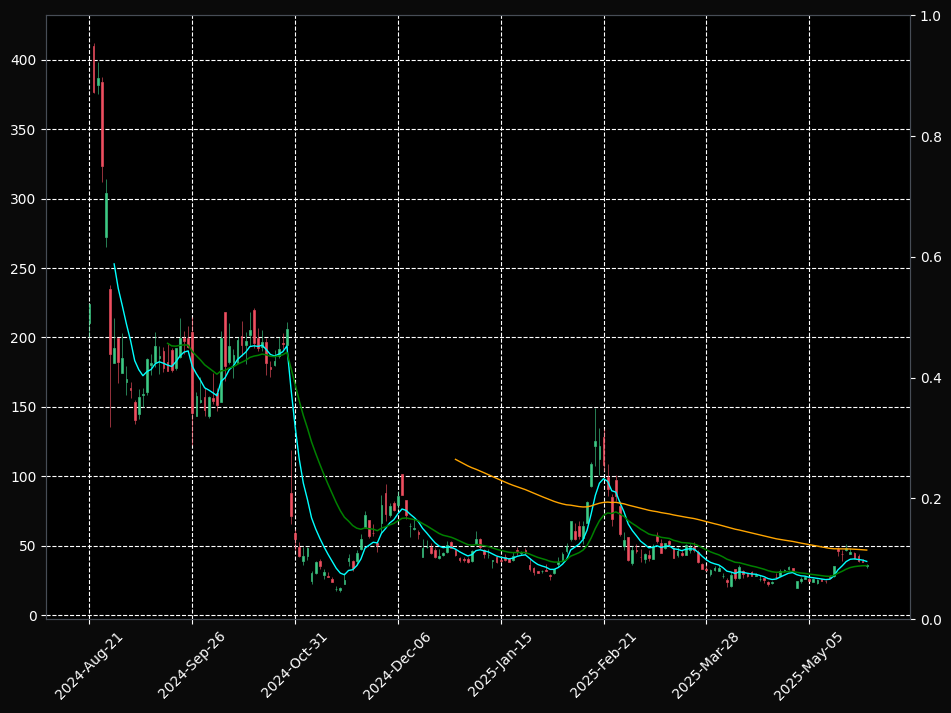

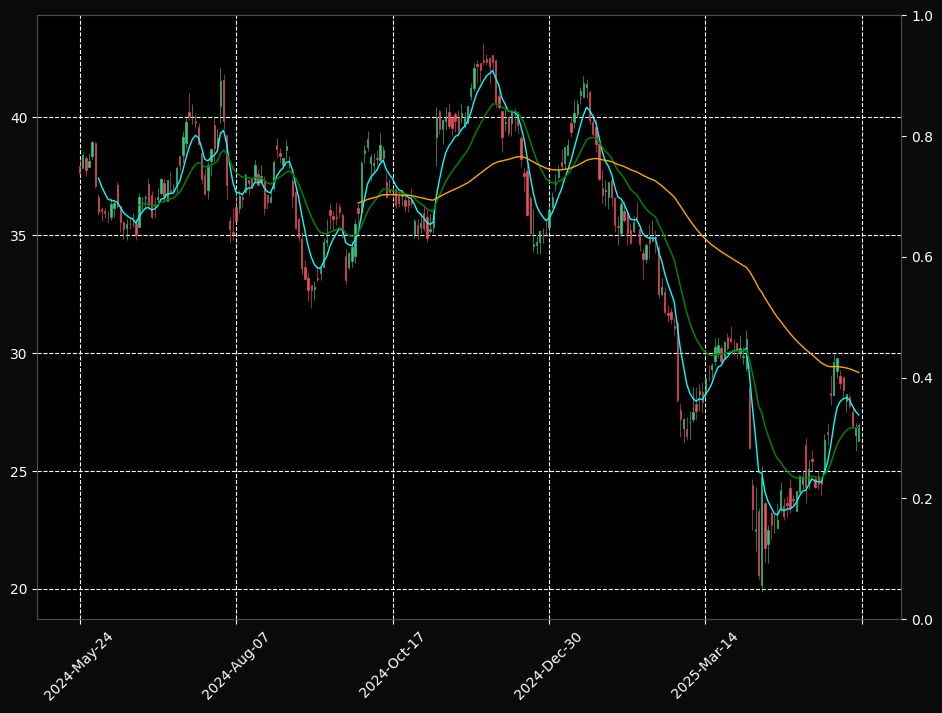

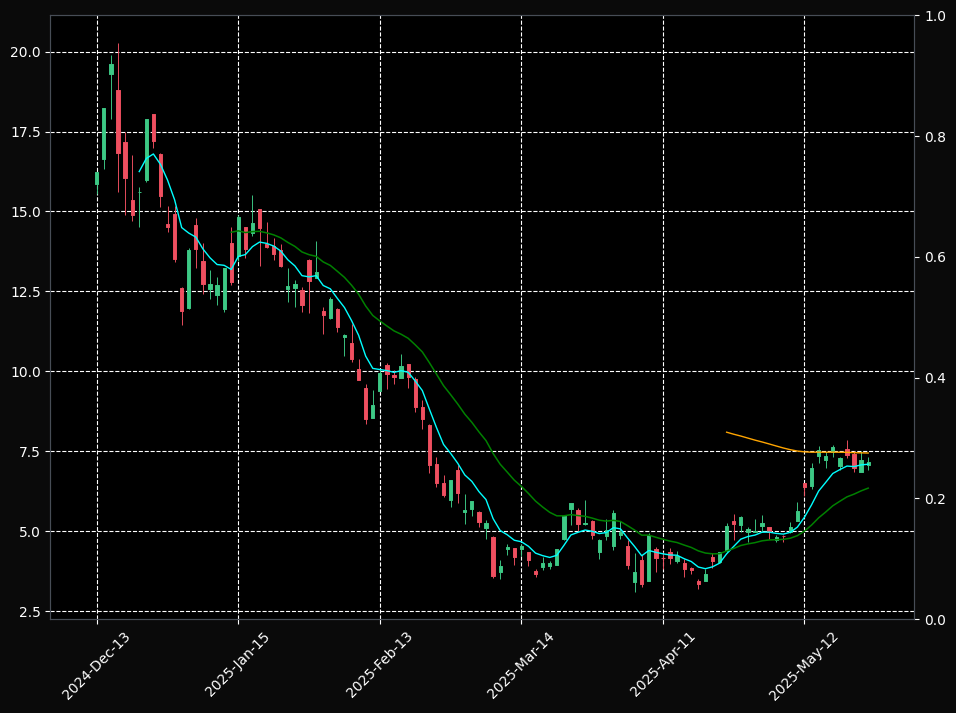

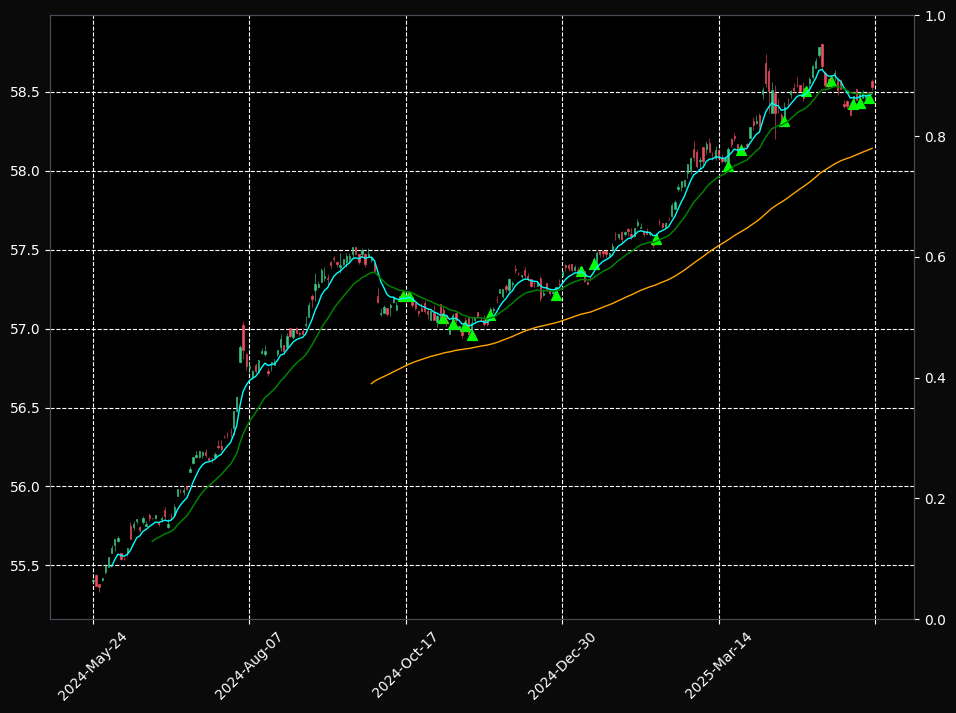

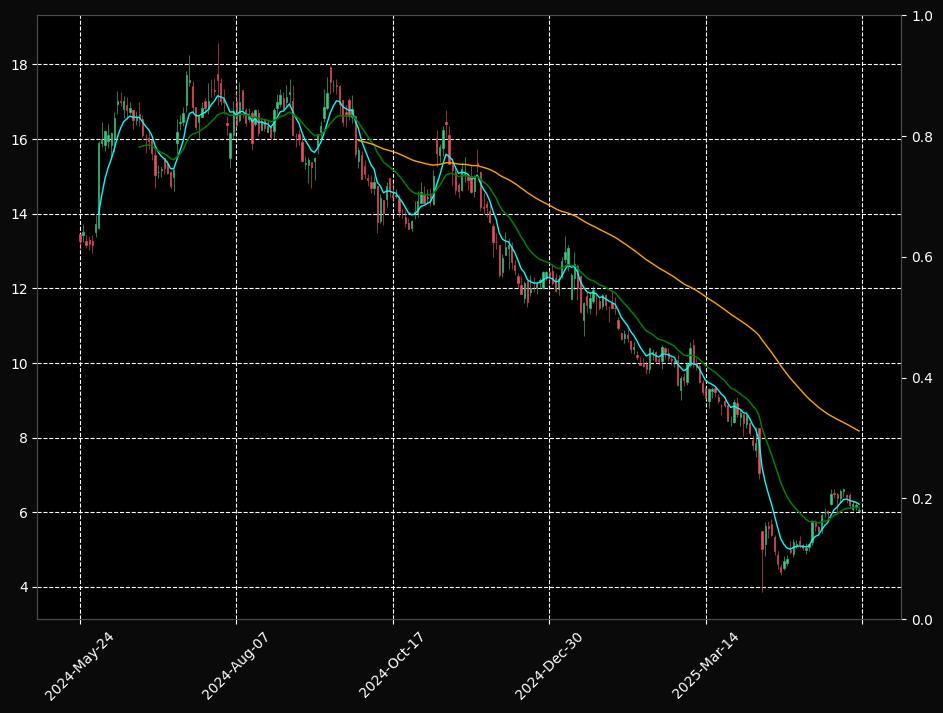

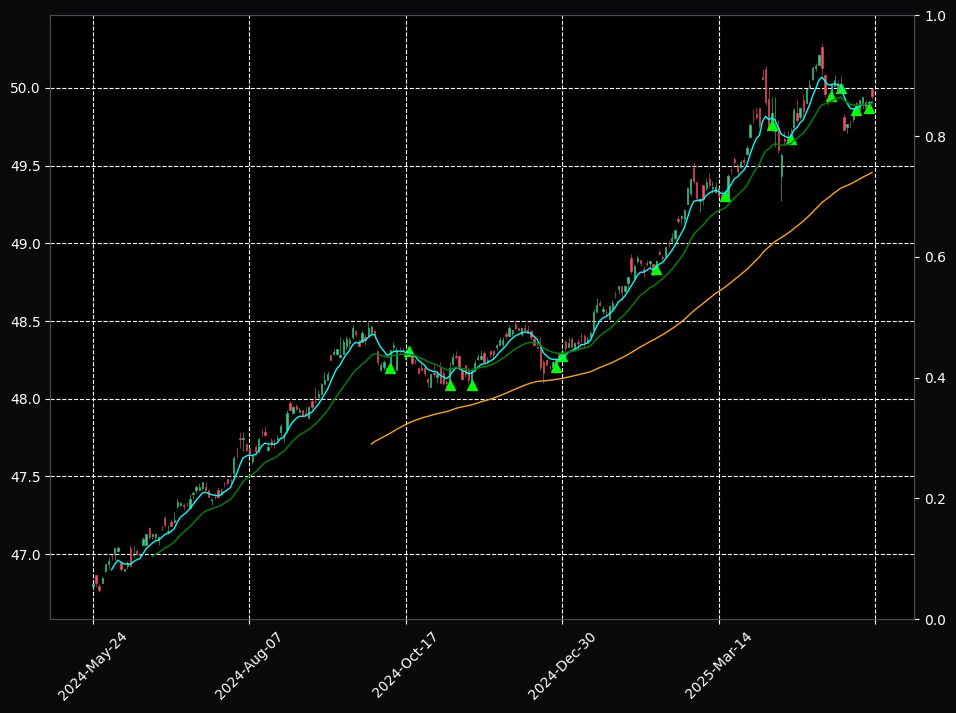

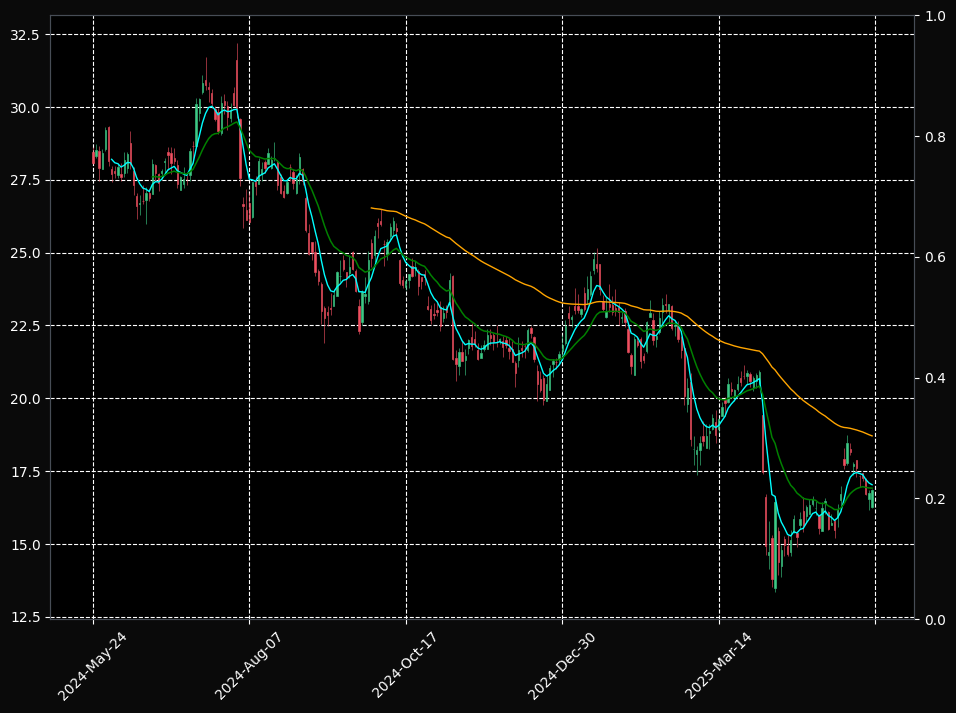

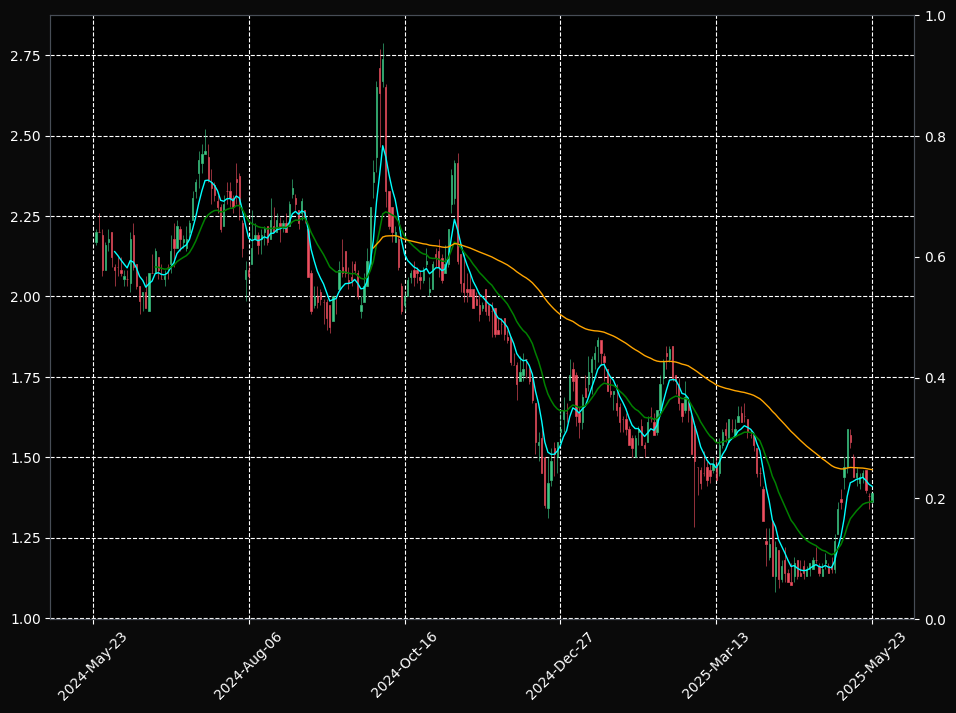

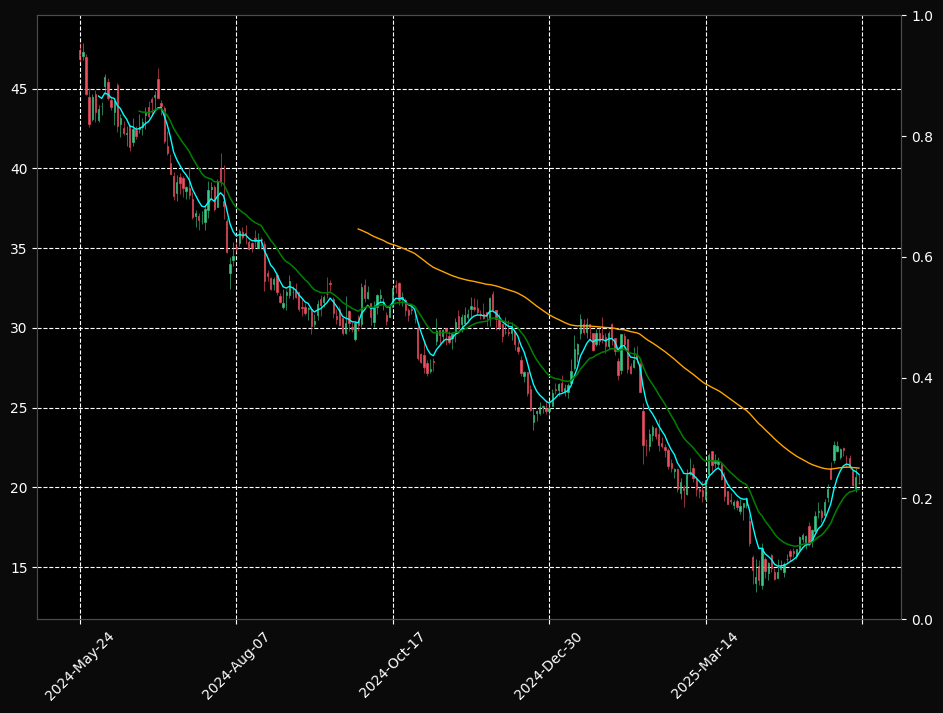

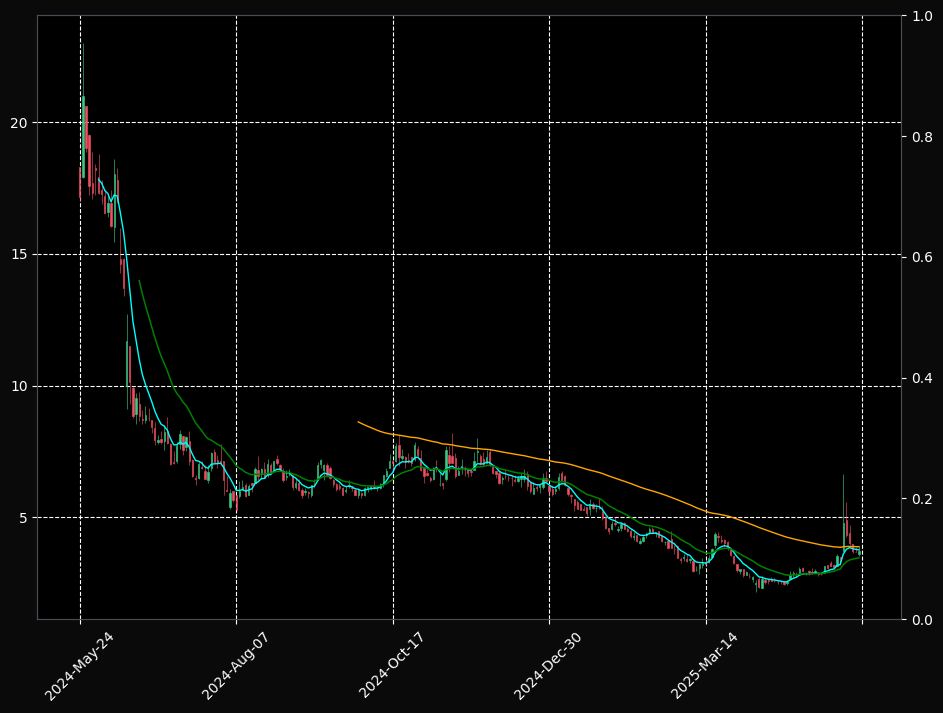

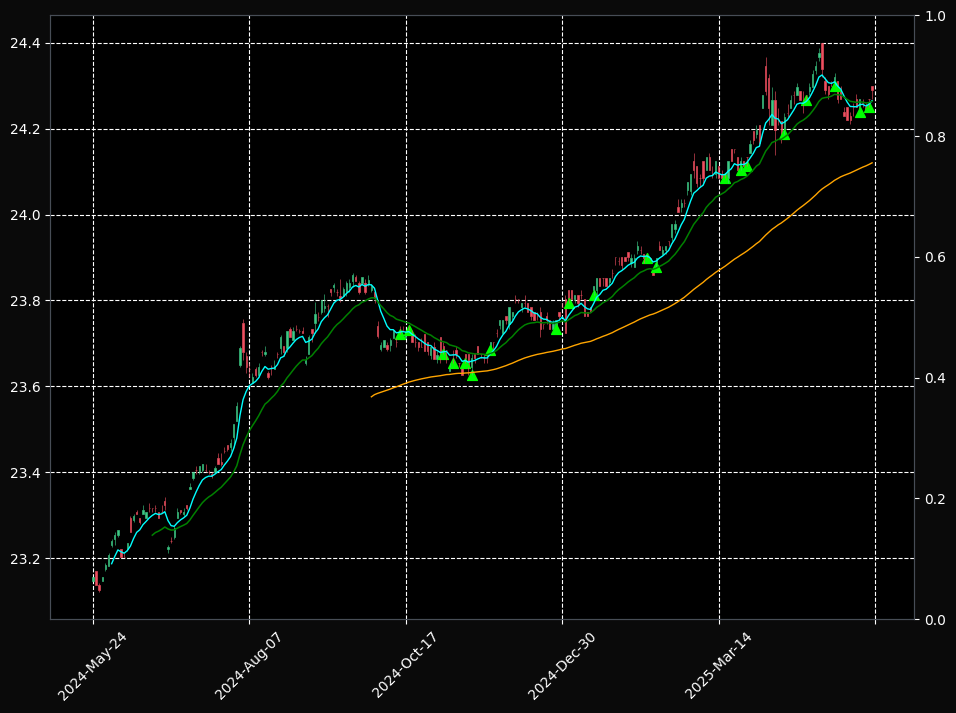

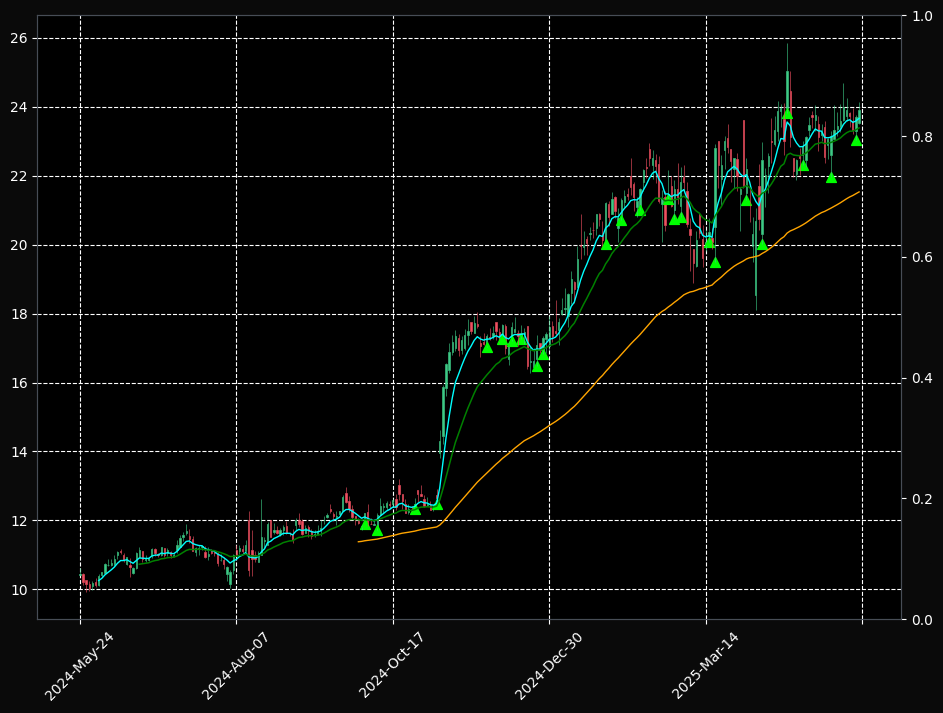

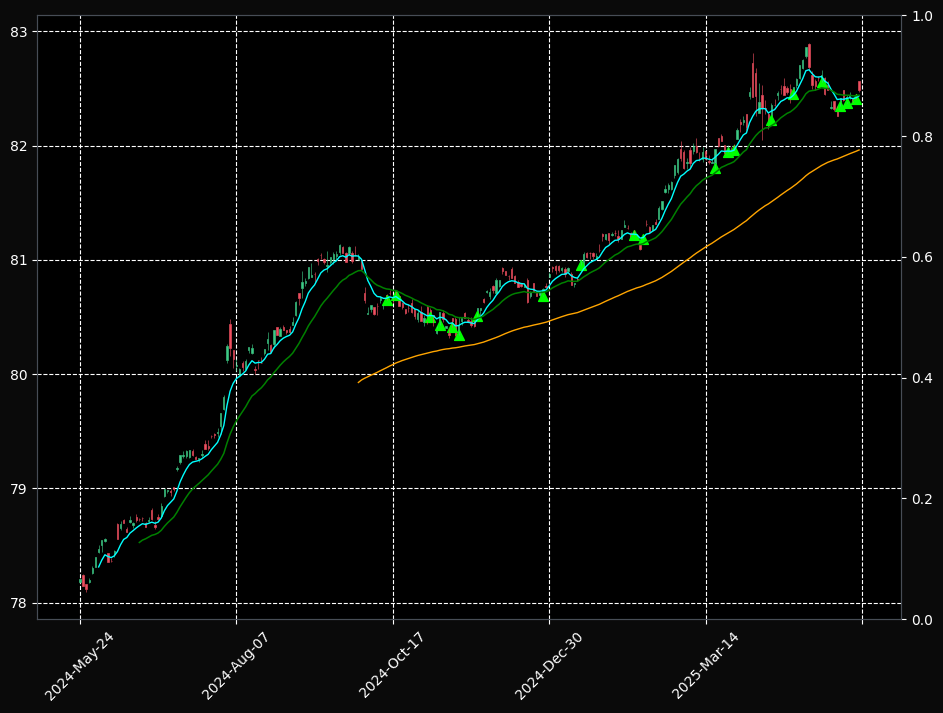

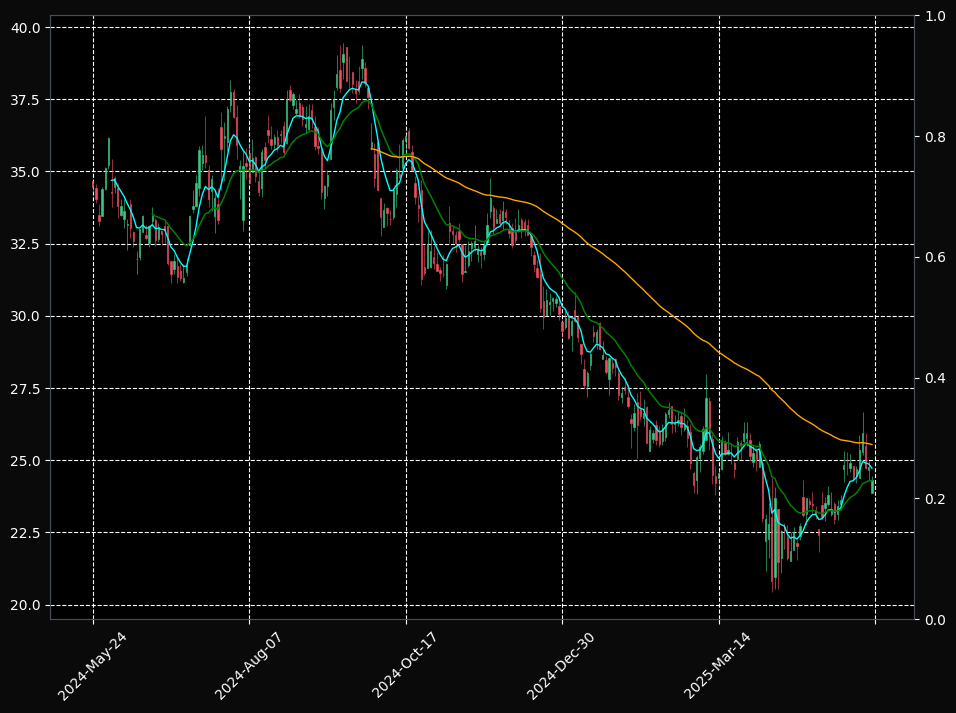

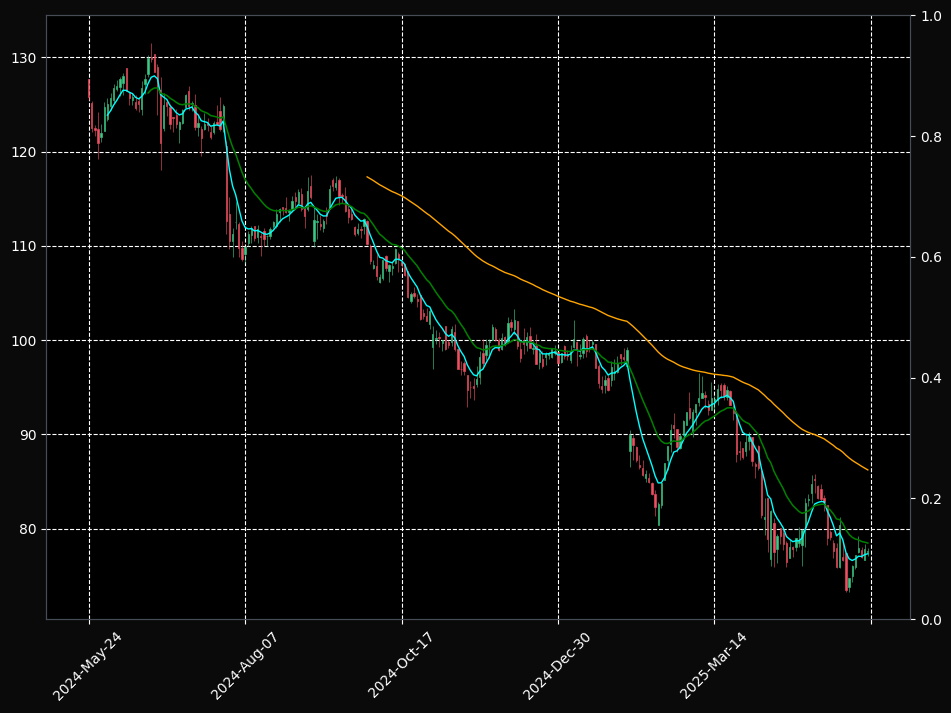

In [26]:
# 4. Create candlestick charts for each symbol
from datetime import datetime

today_str = datetime.today().strftime('%Y-%m-%d')
pdf_output_path = os.path.join(output_dir, f'{today_str}_charts_quqd.pdf')

with PdfPages(pdf_output_path) as pdf:
    for symbol in symbols:
        
        try:
            # Download historical data
            ticker = yf.Ticker(symbol)
            hist_data = ticker.history(period="1y", interval="1d")

            if hist_data.empty:
                print(f"No data found for {symbol}. Skipping.")
                continue
            
            hist_data = compute_qdqu_signals(hist_data)

            entry = hist_data.tail(5)[['bull_entry', 'bear_entry']].any().any()

            if not entry:
                continue

            print(f"Generating chart for {symbol}...")

            # Prepare additional plots
            apds = [
                mpf.make_addplot(hist_data['week_ema'], color='aqua', width=1.0),
                mpf.make_addplot(hist_data['line_ema'], color='green', width=1.1),
                mpf.make_addplot(hist_data['qtr_ema'], color='orange', width=1.0),
                mpf.make_addplot(hist_data['Low'].where(hist_data['bull_entry']), type='scatter', markersize=50, marker='^', color='lime'),
                mpf.make_addplot(hist_data['High'].where(hist_data['bear_entry']), type='scatter', markersize=50, marker='v', color='red'),
            ]

            # Plot with overlays
            fig, axes = mpf.plot(
                hist_data,
                type='candle',
                style='binancedark',
                title=f'{symbol}',
                ylabel='Price',
                addplot=apds,
                figscale=1.5,
                returnfig=True
            )

            # Add the figure to the PDF
            pdf.savefig(fig)
            plt.close(fig) # Close the figure to free up memory

        except Exception as e:
            print(f"Error generating chart for {symbol}: {e}")
            continue

print(f"Candlestick charts saved to {pdf_output_path}")